In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from tqdm.notebook import tqdm, trange
from pert import PERT

from tools import vuln_sim, mcmc_sampler, fit_beta, fit_gamma

In [2]:
dists = {
    'efficacy': PERT(0.9, 0.95, 0.99, 4),
    'variant': PERT(0.01, 0.05, 0.1, 4),
    'occurence': PERT(10, 15, 30, 4),
    'identification': PERT(5, 10, 20, 4),
    'remediation': PERT(5, 10, 20, 4),
}

In [3]:
vuln_vals, variants = vuln_sim(dists, 1000, verbose=True)

In [4]:
occur = dists['occurence'].mean / 365
dur = dists['identification'].mean + dists['remediation'].mean
close_vuln = 1-((1-occur)**dur)

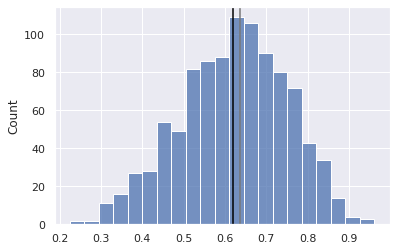

In [5]:
sns.histplot(vuln_vals)
plt.axvline(vuln_vals.mean(), color='#000000')
plt.axvline(close_vuln, color='#777777')

In [6]:
coef_samples = mcmc_sampler(vuln_vals, 10000, mean_seed=close_vuln, verbose=True)

<AxesSubplot:xlabel='gamma', ylabel='Density'>

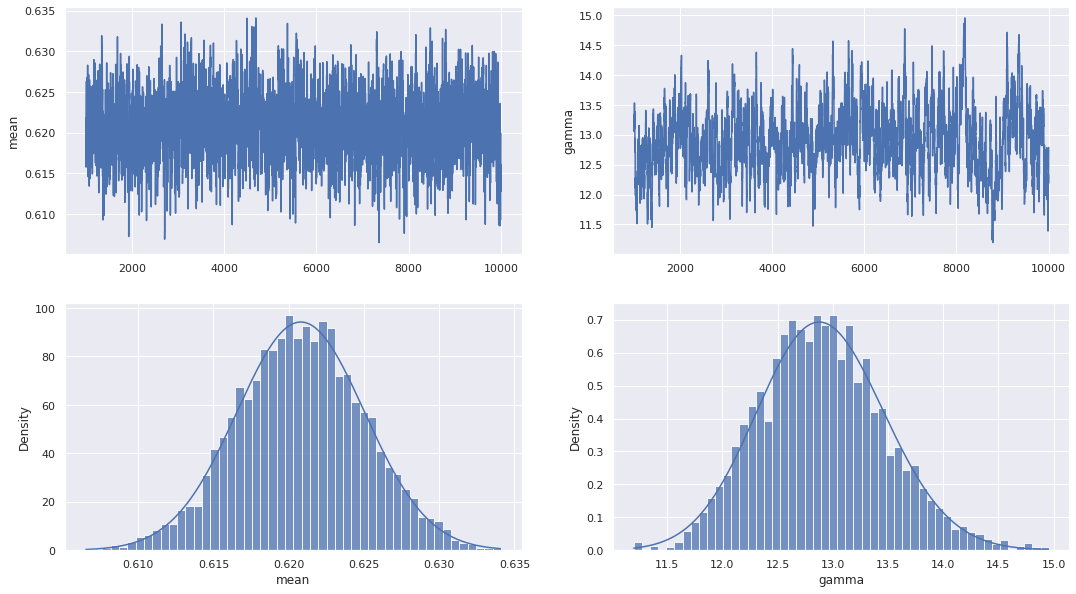

In [7]:
burn_in = 1000
burnt_samples = coef_samples.loc[burn_in:]

fig, ax = plt.subplots(2, 2, figsize=(18,10))
sns.lineplot(x=burnt_samples.index, y=burnt_samples['mean'], ax=ax[0,0])
sns.lineplot(x=burnt_samples.index, y=burnt_samples['gamma'], ax=ax[0,1])
sns.histplot(burnt_samples['mean'], stat='density', ax=ax[1,0])
sns.histplot(burnt_samples['gamma'], stat='density', ax=ax[1,1])

beta_fit = fit_beta(burnt_samples['mean'])
x1 = np.arange(
    burnt_samples['mean'].min(),
    burnt_samples['mean'].max(),
    (burnt_samples['mean'].max() - burnt_samples['mean'].min()) / 1000
)
y1 = stats.beta(beta_fit['alpha'], beta_fit['beta']).pdf(x1)
sns.lineplot(x=x1, y=y1, ax=ax[1,0])

gamma_fit = fit_gamma(burnt_samples['gamma'])
x2 = np.arange(
    burnt_samples['gamma'].min(),
    burnt_samples['gamma'].max(),
    (burnt_samples['gamma'].max() - burnt_samples['gamma'].min()) / 1000
)
y2 = stats.gamma(gamma_fit['shape'], scale=gamma_fit['scale']).pdf(x2)
sns.lineplot(x=x2, y=y2, ax=ax[1,1])

In [8]:
beta_fit

{'alpha': 8146.013273057138, 'beta': 4976.145189524744}

In [9]:
gamma_fit

{'shape': 501.10356049926594, 'scale': 0.025748075715359985}